## **1. Importación de librerias y datos**

In [188]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [189]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size

df_unificado = df_unificado.iloc[:-test_size]
df_unificado.drop(columns=["Fecha"], inplace=True)

print(df_unificado.tail())

     COP/kg      TRM  COP/kg (internacional)   Produccion
59  23462.8  4116.80                34433.20  4485.554779
60  22958.2  4102.67                32237.84  4485.554779
61  23730.8  4168.82                33537.57  4485.554779
62  23407.5  4192.57                33168.13  4485.554779
63  23842.2  4274.03                33146.43  3731.890261


Debido a que las series no son estacionarias, se hace una diferenciación para volverlas **estacionarias** (como lo pide el modelo VAR).

In [ ]:
df_diff = endog_scaled.diff().dropna()
df_diff.head()

,COP/kg,TRM,COP/kg (internacional),Produccion
2,-0.021772,-0.064322,0.128708,0.00000
3,0.038601,0.083591,0.102844,0.00000
4,0.032038,0.049397,0.068796,0.00000
5,0.037346,0.015872,0.211702,0.51988
6,0.095986,-0.011305,0.284488,0.00000


In [191]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # p-value

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    return result[1]  # p-value

def estacionaridad_tests(df):
    resultados = []
    for col in df.columns:
        try:
            adf_p = adf_test(df[col])
            kpss_p = kpss_test(df[col])
            
            if adf_p < 0.05 and kpss_p > 0.05:
                conclusion = "Estacionaria"
            elif adf_p > 0.05 and kpss_p < 0.05:
                conclusion = "No estacionaria"
            else:
                conclusion = "Inconcluso / revisar"
            
            resultados.append({
                "Variable": col,
                "ADF p-value": round(adf_p, 4),
                "KPSS p-value": round(kpss_p, 4),
                "Conclusión": conclusion
            })
        except Exception as e:
            resultados.append({
                "Variable": col,
                "ADF p-value": None,
                "KPSS p-value": None,
                "Conclusión": f"Error: {e}"
            })
    
    return pd.DataFrame(resultados)


resultados_est = estacionaridad_tests(df_diff)
print(resultados_est)


                 Variable  ADF p-value  KPSS p-value    Conclusión
0                  COP/kg          0.0           0.1  Estacionaria
1                     TRM          0.0           0.1  Estacionaria
2  COP/kg (internacional)          0.0           0.1  Estacionaria
3              Produccion          0.0           0.1  Estacionaria


C:\Users\peter\AppData\Local\Temp\ipykernel_7064\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_7064\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_7064\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_7064\3687467595.py:8: InterpolationWarning: The test statistic is ou

## **2. Aplicación del modelo a los datos**

In [192]:
# Crear el modelo VAR
model = VAR(df_diff)

# Selección del rezago óptimo (AIC, BIC, HQIC, FPE)
lag_order_results = model.select_order(maxlags=5)
print(lag_order_results.summary())

# Elegir el rezago con AIC mínimo para este caso
if lag_order_results.aic < 1 or lag_order_results.aic is None:
    best_lag = 1
else:
    best_lag = lag_order_results.aic
    
print(f"Mejor rezago según AIC: {best_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -7.659     -7.515*  0.0004720*     -7.603*
1      -7.510      -6.793   0.0005485      -7.232
2      -7.622      -6.332   0.0004946      -7.121
3     -7.663*      -5.799   0.0004855      -6.939
4      -7.563      -5.126   0.0005594      -6.616
5      -7.644      -4.634   0.0005536      -6.474
-------------------------------------------------
Mejor rezago según AIC: 3


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [193]:
var_model = model.fit(2)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Oct, 2025
Time:                     15:21:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -6.59711
Nobs:                     60.0000    HQIC:                  -7.36219
Log likelihood:          -68.9338    FPE:                0.000391865
AIC:                     -7.85372    Det(Omega_mle):     0.000224050
--------------------------------------------------------------------
Results for equation COP/kg
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.025339         0.038041            0.666           0.505
L1.COP/kg                        -0.225477         0.162922           -1.384           0.166
L1.TRM     

### Revisión de residuos y autocorrelación por variable

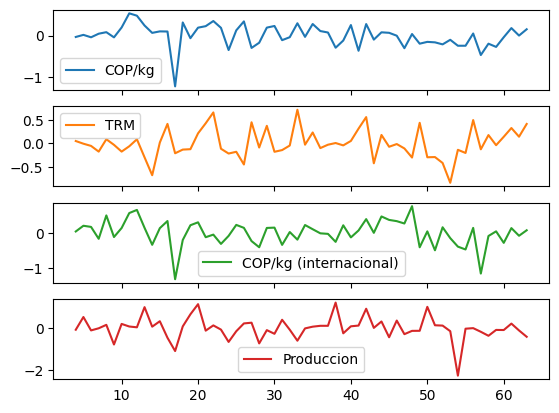

In [195]:
residuos_var = var_model.resid
residuos_var.plot(subplots=True, layout=(len(residuos_var.columns),1))
plt.show()

In [196]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#for col in residuos_var.columns:
#    plot_acf(residuos_var[col])
#    plot_pacf(residuos_var[col])
#plt.show()

for col in residuos_var.columns:
    lb_test_var = acorr_ljungbox(residuos_var[col], lags=[10], return_df=True)
    print(f"Ljung-Box para {col}:\n", lb_test_var)

Ljung-Box para COP/kg:
       lb_stat  lb_pvalue
10  12.625398   0.245377
Ljung-Box para TRM:
      lb_stat  lb_pvalue
10  12.41066   0.258512
Ljung-Box para COP/kg (internacional):
      lb_stat  lb_pvalue
10  7.120998   0.713975
Ljung-Box para Produccion:
      lb_stat  lb_pvalue
10  7.054623   0.720278


1. Prueba de autocorrelación (Ljung-Box, ACF/PACF):  
Se usa para detectar dependencia temporal residual no modelada.  
Si p-valor > 0.05: no se rechaza independencia, residuos adecuados.  
Si p-valor ≤ 0.05: hay autocorrelación, revisar parámetros.  

2. Pruebas de normalidad (Shapiro-Wilk, Jarque-Bera):  
Verifica si residuos siguen distribución normal (supuesto común en modelos clásicos).  
Si p-valor > 0.05: no se rechaza normalidad, validando supuestos.  
Si p-valor ≤ 0.05: residuos no normales, considerar transformaciones sobre COP/kg o métodos robustos (modelos no lineales como LSTM o XGBoost).  

Autovalores del modelo:
[ 0.72606972-2.38944114j  0.72606972+2.38944114j -1.08259814-1.85354733j
 -1.08259814+1.85354733j -1.53053291+0.98554163j -1.53053291-0.98554163j
  1.33363497+0.916581j    1.33363497-0.916581j  ]

¿El sistema es estable? False


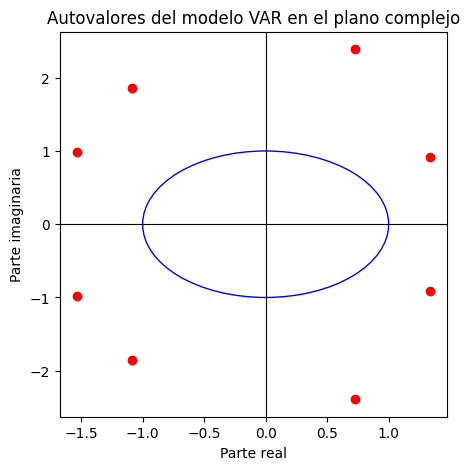

In [197]:
# 1. Ver los autovalores directamente:
eigenvalues = var_model.roots
print("Autovalores del modelo:")
print(eigenvalues)

# 2. Verificar que todos estén dentro del círculo unitario:
stable = np.all(np.abs(eigenvalues) < 1)
print(f"\n¿El sistema es estable? {stable}")

# 3. (Opcional) Visualizar en el plano complejo:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(eigenvalues.real, eigenvalues.imag, color='red')
circle = plt.Circle((0,0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Autovalores del modelo VAR en el plano complejo")
plt.xlabel("Parte real")
plt.ylabel("Parte imaginaria")
plt.show()

In [198]:
# Número de pasos a predecir
n_steps = test_size

forecast = var_model.forecast(df_diff.values[-2:], steps=n_steps)

forecast_df = pd.DataFrame(forecast, 
                           index=pd.date_range(start=df_diff.index[-1], periods=n_steps+1, freq="W")[1:], 
                           columns=df_diff.columns)

print(forecast_df.head())

                                 COP/kg       TRM  COP/kg (internacional)  \
1970-01-11 00:00:00.000000063 -0.199542 -0.033771               -0.140172   
1970-01-18 00:00:00.000000063 -0.142199 -0.069313               -0.057399   
1970-01-25 00:00:00.000000063 -0.005558  0.011487                0.063783   
1970-02-01 00:00:00.000000063  0.017469 -0.026117                0.053619   
1970-02-08 00:00:00.000000063  0.041990  0.014771                0.040662   

                               Produccion  
1970-01-11 00:00:00.000000063   -0.020400  
1970-01-18 00:00:00.000000063   -0.123118  
1970-01-25 00:00:00.000000063   -0.054611  
1970-02-01 00:00:00.000000063    0.004444  
1970-02-08 00:00:00.000000063   -0.014676  


In [199]:
# Tomamos el último valor real en niveles
last_obs = df_unificado.iloc[-1]

# Reconstruimos los niveles sumando acumulativamente las diferencias
forecast_levels = forecast_df.cumsum() + last_obs.values

forecast_levels = pd.DataFrame(forecast_levels, 
                               index=forecast_df.index, 
                               columns=df_unificado.columns)

print(forecast_levels.head())

                                     COP/kg          TRM  \
1970-01-11 00:00:00.000000063  23842.000458  4273.996229   
1970-01-18 00:00:00.000000063  23841.858260  4273.926916   
1970-01-25 00:00:00.000000063  23841.852702  4273.938403   
1970-02-01 00:00:00.000000063  23841.870171  4273.912286   
1970-02-08 00:00:00.000000063  23841.912161  4273.927057   

                               COP/kg (internacional)   Produccion  
1970-01-11 00:00:00.000000063            33146.289828  3731.869860  
1970-01-18 00:00:00.000000063            33146.232430  3731.746742  
1970-01-25 00:00:00.000000063            33146.296213  3731.692131  
1970-02-01 00:00:00.000000063            33146.349832  3731.696575  
1970-02-08 00:00:00.000000063            33146.390493  3731.681900  


In [200]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], forecast_levels['COP/kg'])
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], forecast_levels['COP/kg']))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 3419.9688
RMSE: 4068.1242


## **3. Visualización de los resultados del forecast**

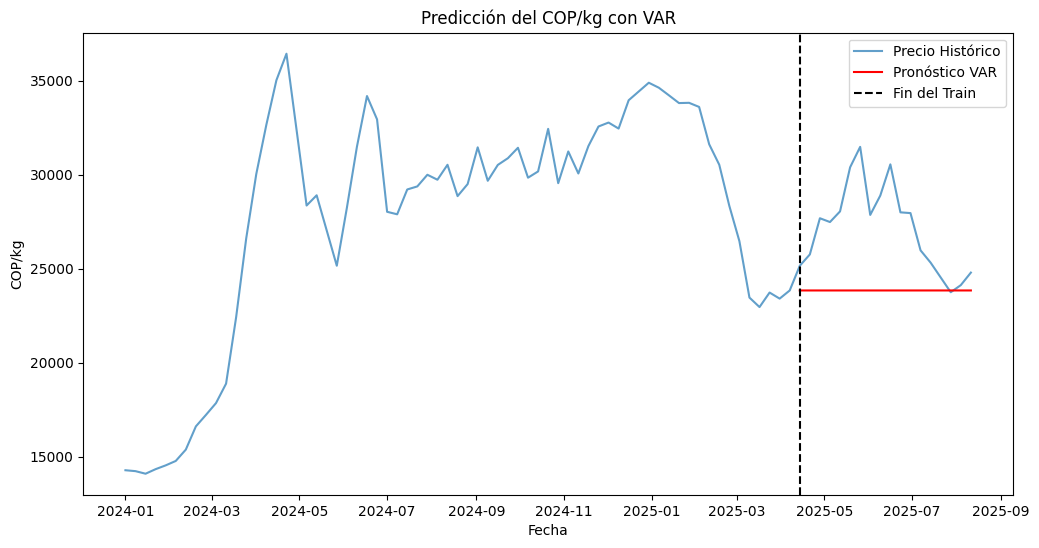

In [201]:
forecast_index = df_total['Fecha'].iloc[train_size:].reset_index(drop=True)
forecast_levels.index = pd.to_datetime(forecast_index)
train_dates = df_total['Fecha'].iloc[:train_size].reset_index(drop=True)

var_name = "COP/kg"  # variable de interés


plt.figure(figsize=(12,6))


plt.plot(df_total['Fecha'], df_total[var_name], label="Precio Histórico", color='C0', alpha=0.7)
plt.plot(forecast_levels.index, forecast_levels[var_name], label="Pronóstico VAR", color="red")
plt.axvline(df_total['Fecha'].iloc[-test_size], color='k', linestyle='--', label='Fin del Train')

plt.title(f"Predicción del {var_name} con VAR")
plt.xlabel("Fecha")
plt.ylabel(var_name)
plt.legend()
plt.show()


## **4. Análisis de impulso-respuesta (IRF)**

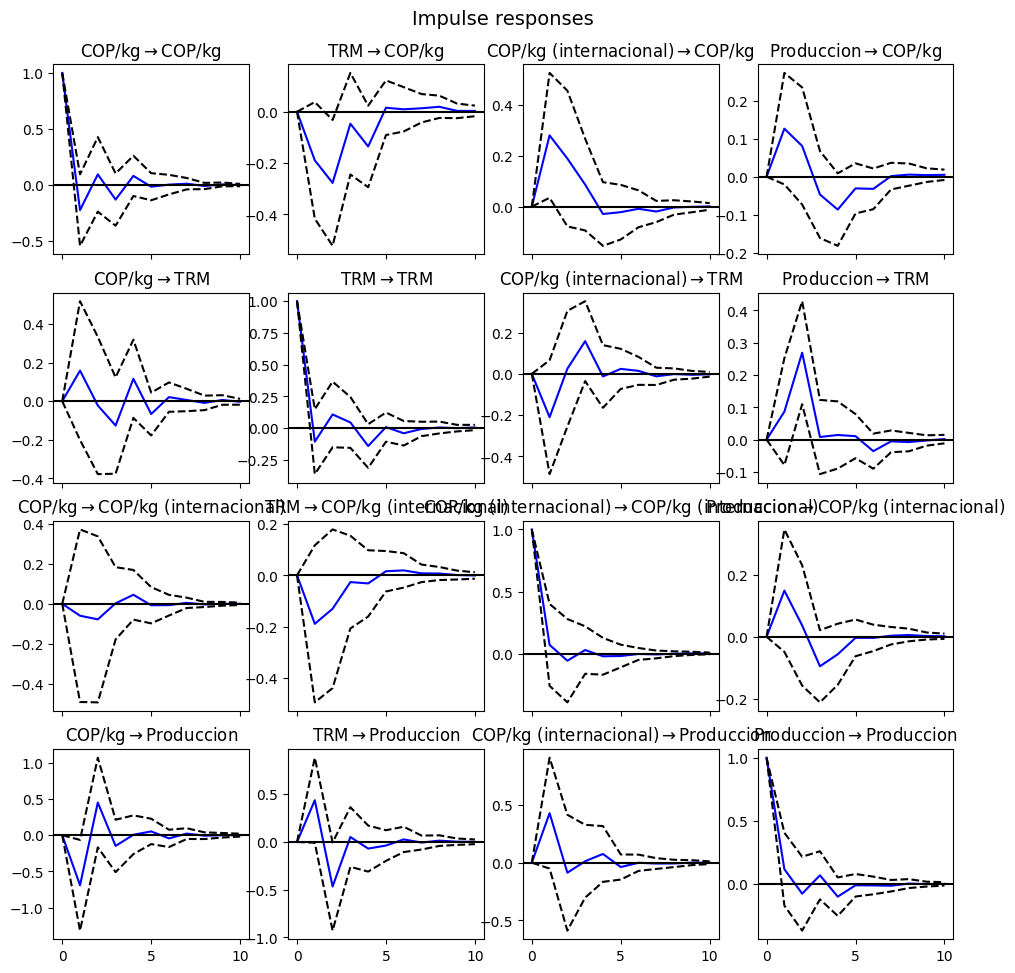

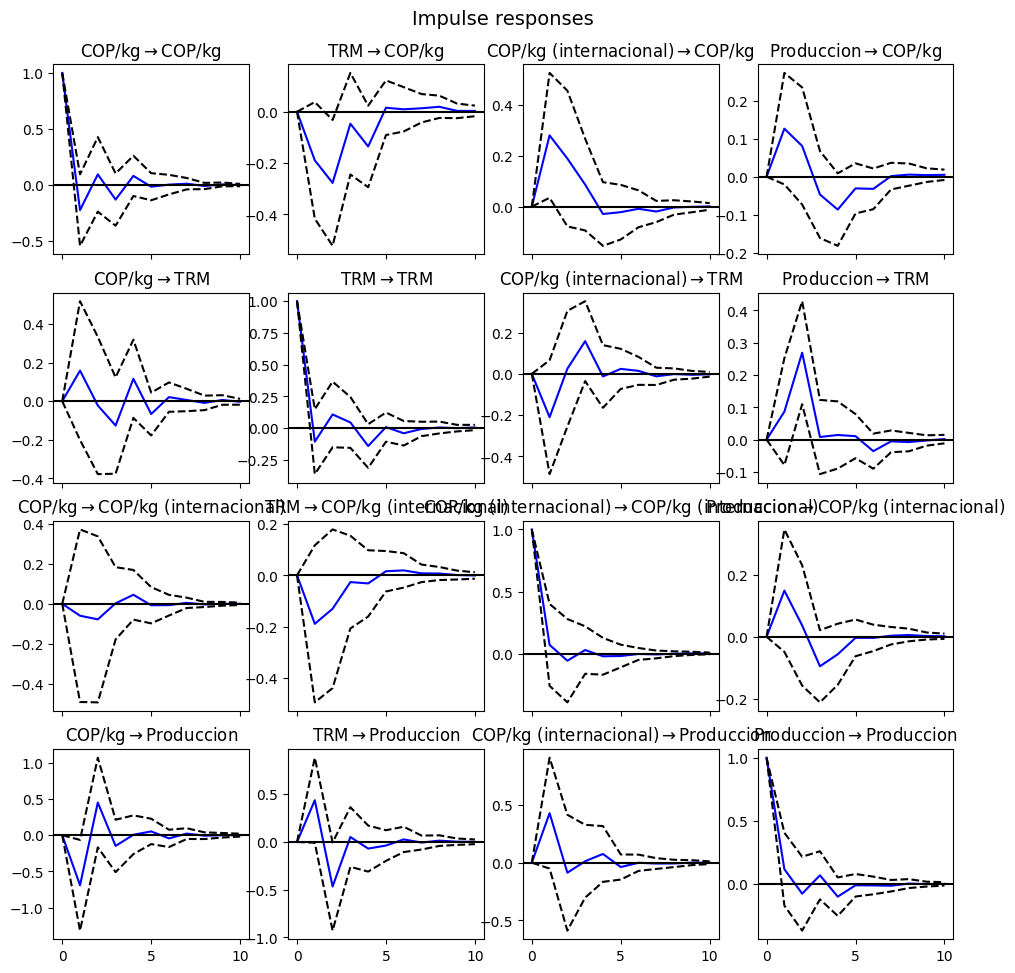

In [202]:
# Horizonte de predicción del shock
irf = var_model.irf(10)

# Graficar respuesta de todas las variables
irf.plot(orth=False)

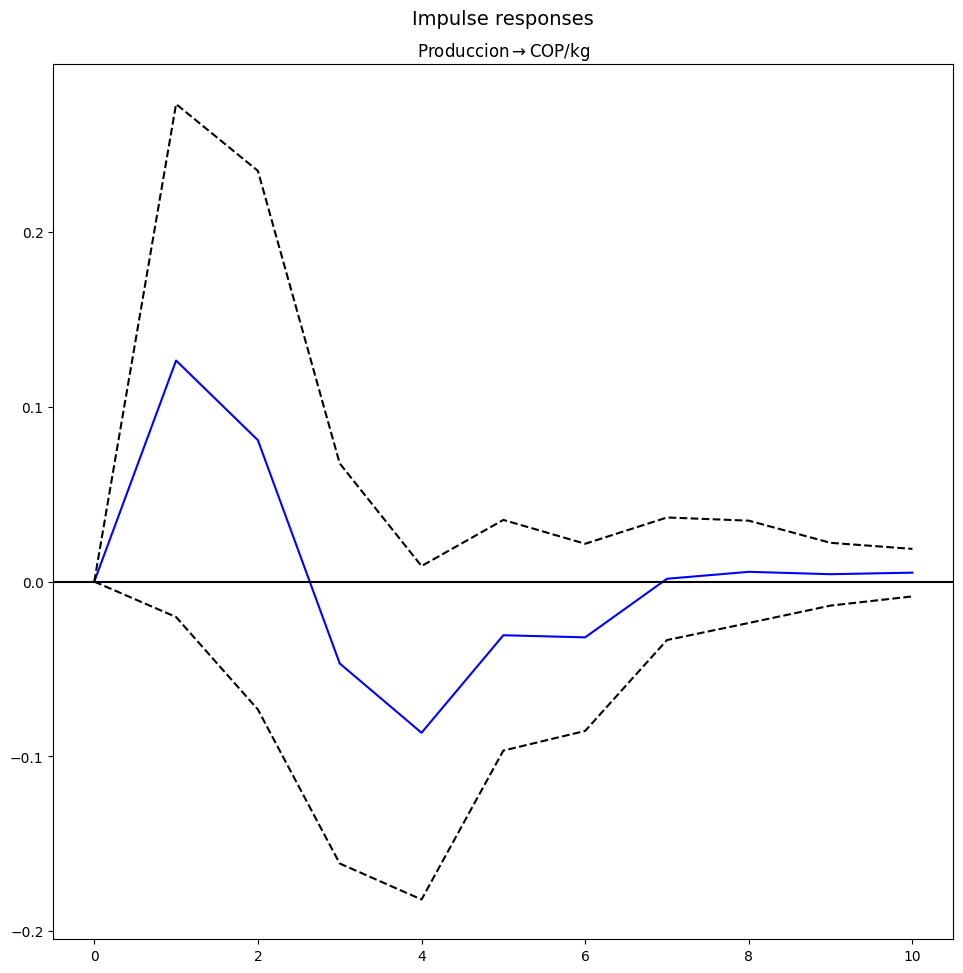

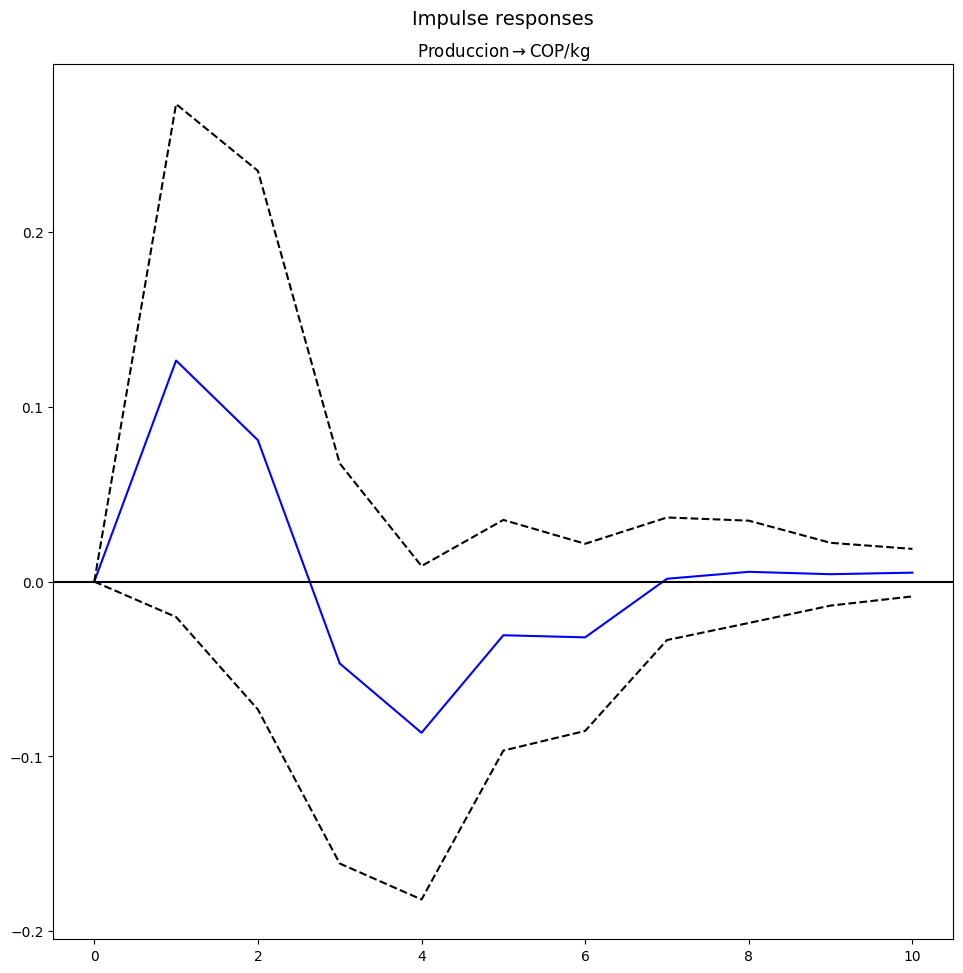

In [203]:
target = "COP/kg"   # variable de interés
shock = "Produccion"  # variable que genera el shock

irf.plot(response=target, impulse=shock, orth=False)